In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fz


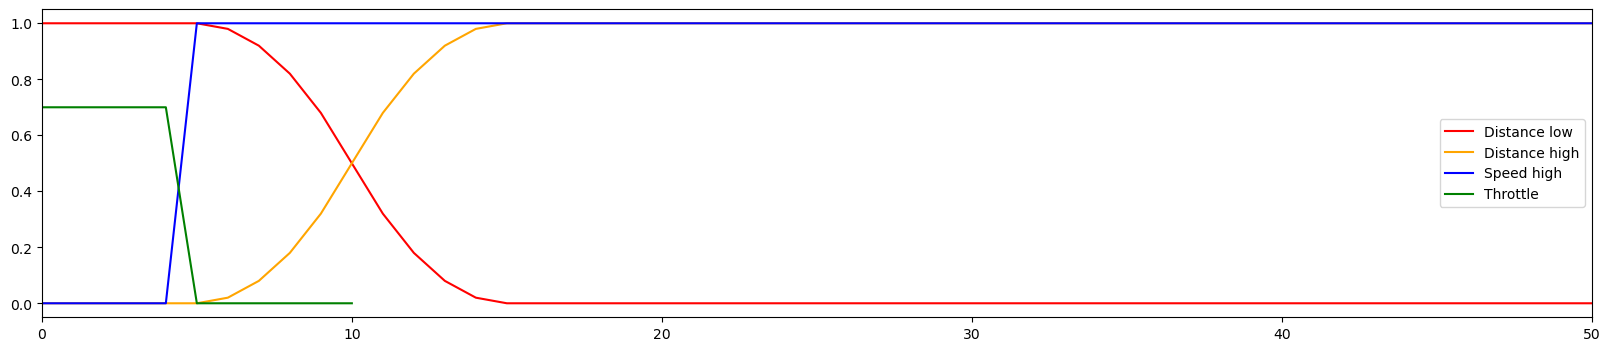

In [23]:
## Throttle (based on distance and speed)
# Variables
x_distance = np.arange(0, 10_000, 1)
x_speed = np.arange(0, 1_000, 1)
x_target_speed = np.arange(0, 1_000, 1)

# Membership functions
dist_lo = fz.zmf(x_distance, 5, 15)
dist_hi = fz.smf(x_distance, 5, 15)
speed_hi = fz.smf(x_speed, 4, 5)

def throttle(distance, speed, limit):
    dst = fz.interp_membership(x_distance, dist_hi, distance)
    spd = fz.interp_membership(x_speed, speed_hi, limit - speed)

    t = dst * spd

    return np.clip(t, 0.0, 0.7)

plt.figure(figsize=(20, 4))

plt.plot(x_distance, dist_lo, color='red', label='Distance low')
plt.plot(x_distance, dist_hi, color='orange', label='Distance high')
plt.plot(x_speed, speed_hi, color='blue', label='Speed high')

plt.xlim(0, 50)

r = [
    [100, 10, 30],
    [90, 12, 30],
    [80, 15, 30],
    [70, 20, 30],
    [60, 25, 30],
    [50, 30, 30],
    [40, 30, 30],
    [30, 30, 30],
    [20, 30, 30],
    [10, 30, 30],
    [0, 30, 30],
]

x = np.arange(0, len(r), 1)
y = [throttle(d, s, l) for d, s, l in r]

plt.plot(x, y, color='green', label='Throttle')

plt.legend()
plt.show()

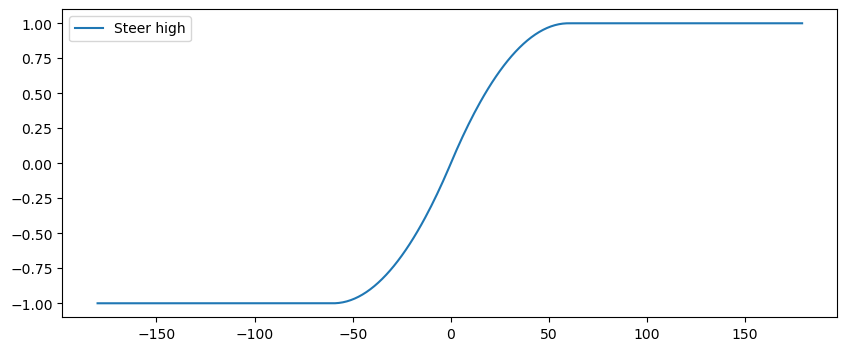

In [24]:
## Steering (based on angle and direction)
# Variables
x_steer = np.arange(-180, 180, 1)

# Membership functions
steer_hi = fz.smf(x_steer, -60, 60)

plt.figure(figsize=(10, 4))

plt.plot(x_steer, (steer_hi - 0.5) * 2, label='Steer high')

plt.legend()
plt.show()

In [18]:
source = [22.5959, -4.3443]
destination = [22, -4]

# Normalize both vectors
source /= np.linalg.norm(source)
destination /= np.linalg.norm(destination)

# Calculate dot product between vectors
dot_product = np.dot(source, destination)

# Calculate cross product between vectors
cross_product = np.cross(source, destination)

# Calculate angle in radians
angle_radians = np.arccos(dot_product)

# Determine direction of angle using cross product
if cross_product < 0:
    angle_radians = -angle_radians

# Convert angle from radians to degrees
angle_degrees = np.degrees(angle_radians)

print(angle_degrees)

0.0


In [3]:
def angle(a, b):
    # Normalize both vectors
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)

    # Calculate dot product between vectors
    dot_product = np.dot(a, b)

    # Calculate cross product between vectors
    cross_product = np.cross(a, b)

    # Calculate angle in radians
    angle_radians = np.arccos(dot_product)

    # Determine direction of angle using cross product
    if cross_product[2] < 0:
        angle_radians = -angle_radians

    # Convert angle from radians to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

v1 = [27.5, -5]
v2 = [22, -4]

angle = angle(v1, v2)

print(f'Angle between vectors: {angle:.2f} rad, {np.degrees(angle):.2f} deg')

plt.figure(figsize=(4, 4))

plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color='black', label='car')
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color='red', label='destination')


dx = v1[0] * np.cos(angle) - v1[1] * np.sin(angle)
dy = v1[1] * np.cos(angle) + v1[0] * np.sin(angle)
d = [dx, dy]

plt.quiver(0, 0, d[0], d[1], angles='xy', scale_units='xy', scale=1, color='green', label='steer')

plt.legend()
plt.show()


0.0


IndexError: too many indices for array